In [1]:
import utils
import numpy as np
import netCDF4
import pandas as pd
import xarray as xr
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import colors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from esem import rf_model
from esem.utils import leave_one_out
import joblib


2025-12-03 14:56:32.769621: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-03 14:56:33.162597: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-03 14:56:38.963824: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
train_files = ["historical", "ssp126", "ssp370", 'hist-aer', 'hist-GHG']
tasFiles = ["historical", "ssp126", "ssp370", "hist-aer", "hist-GHG"]
# Create training and testing arrays
X, solvers = utils.create_predictor_data(train_files)
Y = utils.create_predictdand_data(tasFiles)

In [3]:
# Get test data (SSP 245)
test_X = utils.get_test_data('ssp245', solvers)
test_Y = utils.create_predictdand_data(['ssp245'])

In [4]:
X

,CO2,CH4,BC_0,BC_1,BC_2,BC_3,BC_4,SO2_0,SO2_1,SO2_2,SO2_3,SO2_4
0,0.000020,0.039132,-0.601230,-0.031219,-0.373334,-0.998888,-0.085261,-0.772566,-0.432152,-0.478267,-0.053410,-0.515110
1,0.000040,0.039677,-0.601461,-0.027164,-0.355117,-0.976966,-0.095346,-0.774552,-0.428590,-0.484248,-0.076719,-0.506201
2,0.000060,0.040222,-0.602826,-0.047422,-0.366245,-0.967133,-0.091882,-0.771749,-0.429983,-0.482126,-0.077670,-0.505171
3,0.000082,0.040767,-0.604149,-0.067713,-0.376708,-0.956885,-0.088576,-0.769847,-0.430776,-0.481345,-0.078535,-0.500874
4,0.000107,0.041312,-0.610915,-0.192337,-0.517823,-1.002746,-0.027671,-0.747018,-0.452742,-0.449240,0.021076,-0.511202
...,...,...,...,...,...,...,...,...,...,...,...,...
662,0.143274,0.446273,-0.823262,1.093213,0.267432,-0.279555,-0.792217,-0.910456,-0.314869,-0.658289,-0.590748,-0.435009
663,0.146844,0.450689,-0.823262,1.093213,0.267432,-0.279555,-0.792217,-0.910456,-0.314869,-0.658289,-0.590748,-0.435009
664,0.150465,0.458138,-0.823262,1.093213,0.267432,-0.279555,-0.792217,-0.910456,-0.314869,-0.658289,-0.590748,-0.435009
665,0.154191,0.462215,-0.823262,1.093213,0.267432,-0.279555,-0.792217,-0.910456,-0.314869,-0.658289,-0.590748,-0.435009


### Building Model

In [10]:
# import AFTER data read in and processed. Having issues with reading in data
import esem
from esem import gp_model
from esem.data_processors import Whiten, Normalise

# very simple GP with default kernel assuming all years are independant
tas_gp = gp_model(X, Y["tas"])
tas_gp.train()

pr_gp = gp_model(X, Y["pr"])
pr_gp.train()

dtr_gp = gp_model(X, Y["diurnal_temperature_range"])
dtr_gp.train()

pr90_gp = gp_model(X, Y["pr90"])
pr90_gp.train()

2025-12-03 13:47:48.982878: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
# build test set
tas_truth = test_Y["tas"]
pr_truth = test_Y["pr"]
pr90_truth = test_Y["pr90"]
dtr_truth = test_Y["diurnal_temperature_range"]

### Baseline Model Test Predictions

In [16]:
m_out_tas, _ = tas_gp.predict(test_X)
m_out_pr, _ = pr_gp.predict(test_X)
m_out_pr90, _ = pr90_gp.predict(test_X)
m_out_dtr, _ = dtr_gp.predict(test_X)

In [19]:
print(f"NRMSE spatial tas: {utils.nrmse_spatial(tas_truth[65:], m_out_tas[65:]).mean()}")
print(f"NRMSE global tas: {utils.nrmse_global(tas_truth[65:], m_out_tas[65:]).mean()}")
print(f"NRMSE total tas: {utils.nrmse_total(tas_truth[65:], m_out_tas[65:]).mean()}")

NRMSE spatial tas: 0.23336049706298928
NRMSE global tas: 0.11620088993358776
NRMSE total tas: 0.8143649467309281


In [21]:
print(f"NRMSE spatial dtr: {utils.nrmse_spatial(dtr_truth[65:], m_out_dtr[65:]).mean()}")
print(f"NRMSE global dtr: {utils.nrmse_global(dtr_truth[65:],  m_out_dtr[65:]).mean()}")
print(f"NRMSE total dtr: {utils.nrmse_total(dtr_truth[65:], m_out_dtr[65:]).mean()}")

NRMSE spatial dtr: 28.49903914262335
NRMSE global dtr: 3.7191364524265786
NRMSE total dtr: 47.09472140475624


In [22]:
print(f"NRMSE spatial pr: {utils.nrmse_spatial(pr_truth[65:], m_out_pr[65:]).mean()}")
print(f"NRMSE global pr: {utils.nrmse_global(pr_truth[65:], m_out_pr[65:]).mean()}")
print(f"NRMSE total pr: {utils.nrmse_total(pr_truth[65:], m_out_pr[65:]).mean()}")

NRMSE spatial pr: 9.372758743641995
NRMSE global pr: 0.4148506163027979
NRMSE total pr: 11.447011825155986


In [23]:
print(f"NRMSE spatial pr90: {utils.nrmse_spatial(pr90_truth[65:], m_out_pr90[65:]).mean()}")
print(f"NRMSE global pr90: {utils.nrmse_global(pr90_truth[65:],  m_out_pr90[65:]).mean()}")
print(f"NRMSE total pr90: {utils.nrmse_total(pr90_truth[65:],  m_out_pr90[65:]).mean()}")

NRMSE spatial pr90: 11.846148247503033
NRMSE global pr90: 0.371315514327086
NRMSE total pr90: 13.702725819138465


### GP kernels
-  model = gp_model(X_train, Y_train, kernel=['Linear', 'Cosine'], kernel_op='add')

- kernel
    - This controls the covariance (or kernel) function of the Gaussian Process.
    - By default, ESEm uses a combination of linear, RBF, and polynomial kernels.
- kernel_op
    - this determines how multiple kernels are combined: 'add' (sum of kernels) or 'mul' (product of kernels).
    - This is helpful if you want more expressive covariance functions (e.g., a periodic part times a linear trend).

chatgpt says these are common 'good combos':
- ['RBF']
- ['Matern32']
- ['Cosine', 'Linear']
- ['RBF', 'Linear']
- ['Matern52', 'Cosine']
Documentation can be found here: https://esem.readthedocs.io/en/latest/emulation.html

In [15]:
def model_kernels(colonel, op):
    """
    Train GP models for different climate variables using specified kernel configuration.
    Returns RMSEs so that we can compare kernels.
    """
    models = {
        "tas": gp_model(X, Y["tas"], kernel=colonel, kernel_op=op),
        "pr": gp_model(X, Y["pr"], kernel=colonel, kernel_op=op),
        "dtr": gp_model(X, Y["diurnal_temperature_range"], kernel=colonel, kernel_op=op),
        "pr90": gp_model(X, Y["pr90"], kernel=colonel, kernel_op=op) }

    for m in models.values():
        m.train()
    preds = {name: model.predict(test_X)[0] for name, model in models.items()}

    rmse = {
        "tas": utils.get_rmse(tas_truth, preds["tas"]),
        "dtr": utils.get_rmse(dtr_truth, preds["dtr"]),
        "pr": utils.get_rmse(pr_truth, preds["pr"]),
        "pr90": utils.get_rmse(pr90_truth, preds["pr90"]) }

    print(f"RMSE for kernel={colonel}, op={op}: {rmse}")
    return rmse

In [16]:
def testModels():
    kernel_candidates = [['Linear', 'Polynomial'], ['Cosine', 'Linear'], ['RBF'], ['Matern32'], ['RBF', 'Linear'], ['Matern52', 'Cosine']]
    ops = ['add', 'mul']
    results = []

    for k in kernel_candidates:
        for op in ops:
            rmse = model_kernels(k, op)
            results.append((k, op, rmse))
    return

# This can take 60+ minutes fair warning
testModels()

RMSE for kernel=['Linear', 'Polynomial'], op=add: {'tas': array(0.8069459), 'dtr': array(0.18208877), 'pr': array(0.61118874), 'pr90': array(1.75199018)}
RMSE for kernel=['Linear', 'Polynomial'], op=mul: {'tas': array(0.83033842), 'dtr': array(0.18183894), 'pr': array(0.63177948), 'pr90': array(1.81883311)}
RMSE for kernel=['Cosine', 'Linear'], op=add: {'tas': array(0.82998233), 'dtr': array(0.18213001), 'pr': array(0.61112412), 'pr90': array(1.7519892)}
RMSE for kernel=['Cosine', 'Linear'], op=mul: {'tas': array(2.09944838), 'dtr': array(0.2870564), 'pr': array(0.64439374), 'pr90': array(1.86746793)}
RMSE for kernel=['RBF'], op=add: {'tas': array(0.81838417), 'dtr': array(0.17785812), 'pr': array(0.60407864), 'pr90': array(1.73652377)}
RMSE for kernel=['RBF'], op=mul: {'tas': array(0.81838417), 'dtr': array(0.17785812), 'pr': array(0.60407864), 'pr90': array(1.73652377)}
RMSE for kernel=['Matern32'], op=add: {'tas': array(0.80361186), 'dtr': array(0.17758645), 'pr': array(0.61006515),

In [5]:
# generally best kernel is RBF so we use it to visualize
import esem
from esem import gp_model
from esem.data_processors import Whiten, Normalise

tas_gp = gp_model(X, Y["tas"], kernel=['RBF'], kernel_op='add')
tas_gp.train()

m_tas, _ = tas_gp.predict(test_X)
m_tas = m_tas.rename({"sample": "time"})

W0000 00:00:1764799090.295096   21209 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
m_tas = m_tas.assign_coords(time=tas_truth.time.values)

print(f"NRMSE spatial tas: {utils.nrmse_spatial(tas_truth[65:], m_tas[65:]).mean()}")
print(f"NRMSE global tas: {utils.nrmse_global(tas_truth[65:], m_tas[65:]).mean()}")
print(f"NRMSE total tas: {utils.nrmse_total(tas_truth[65:], m_tas[65:]).mean()}")

NRMSE spatial tas: 0.20341884772589772
NRMSE global tas: 0.08834548755172388
NRMSE total tas: 0.645146285484517


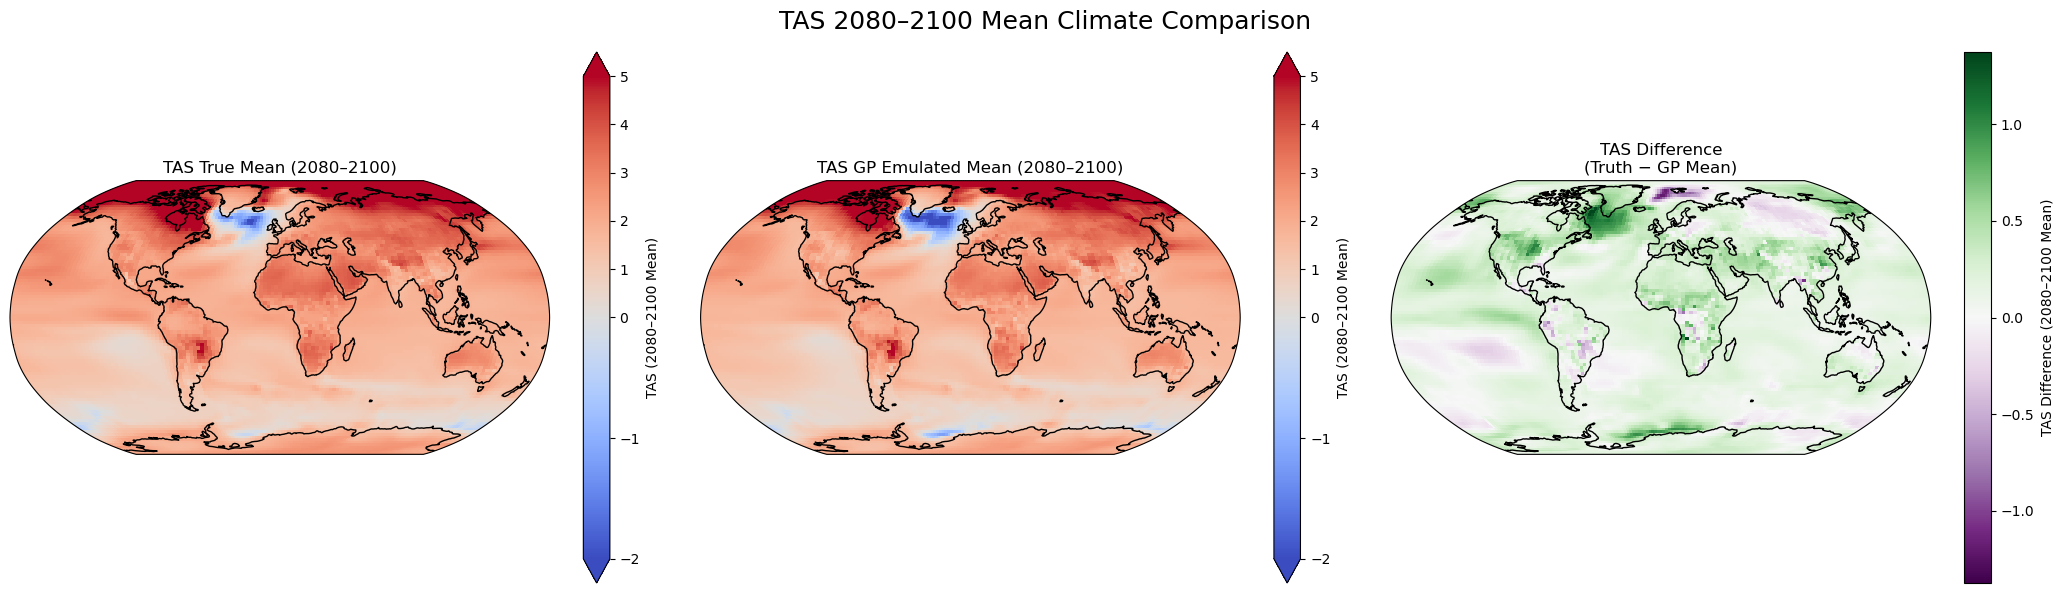

In [8]:
utils.plot_mean_2080_2100(tas_truth, m_tas, "TAS", savefig = True, Model = "GP")

In [11]:
pr_gp = gp_model(X, Y["pr"], kernel=['RBF'], kernel_op='add')
pr_gp.train()

m_pr, _ = pr_gp.predict(test_X)
m_pr = m_pr.rename({"sample": "time"})

In [16]:
m_pr = m_pr.assign_coords(time=tas_truth.time.values)

print(f"NRMSE spatial pr: {utils.nrmse_spatial(pr_truth[65:], m_pr[65:]).mean()}")
print(f"NRMSE global pr: {utils.nrmse_global(pr_truth[65:], m_pr[65:]).mean()}")
print(f"NRMSE total pr: {utils.nrmse_total(pr_truth[65:], m_pr[65:]).mean()}")

NRMSE spatial pr: 9.274381729626109
NRMSE global pr: 0.2905115404995882
NRMSE total pr: 10.726939432124048


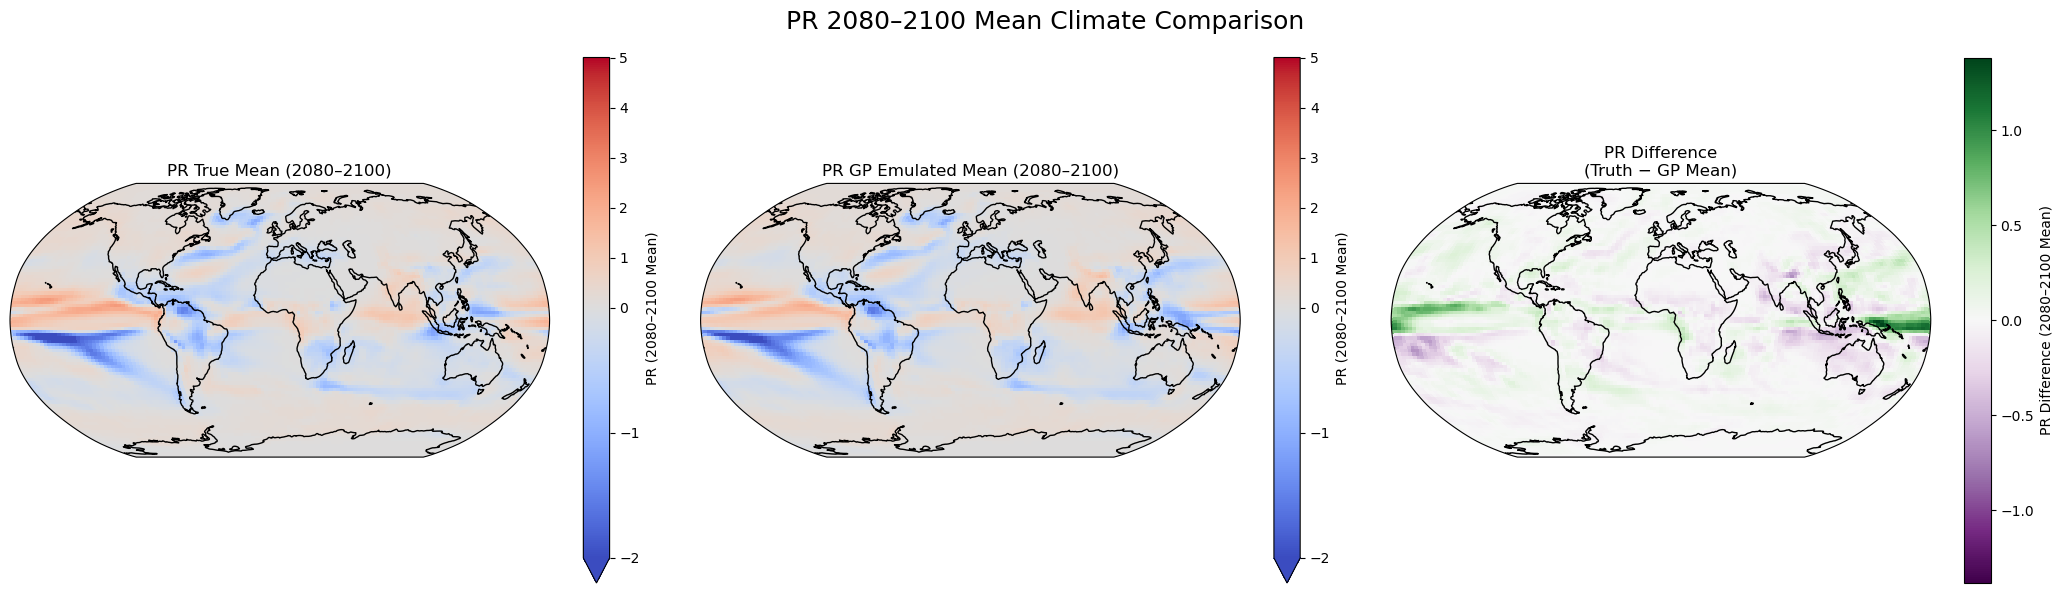

In [12]:
utils.plot_mean_2080_2100(pr_truth, m_pr, "PR", savefig = True, Model = "GP")

In [9]:
pr90_gp = gp_model(X, Y["pr90"], kernel=['RBF'], kernel_op='add')
pr90_gp.train()

m_pr90, _ = pr90_gp.predict(test_X)
m_pr90 = m_pr90.rename({"sample": "time"})

In [10]:
m_pr90 = m_pr90.assign_coords(time=tas_truth.time.values)

print(f"NRMSE spatial pr90: {utils.nrmse_spatial(pr90_truth[65:], m_pr90[65:]).mean()}")
print(f"NRMSE global pr90: {utils.nrmse_global(pr90_truth[65:], m_pr90[65:]).mean()}")
print(f"NRMSE total pr90: {utils.nrmse_total(pr90_truth[65:], m_pr90[65:]).mean()}")

NRMSE spatial pr90: 11.704519054836835
NRMSE global pr90: 0.2712194228845889
NRMSE total pr90: 13.060616169259779


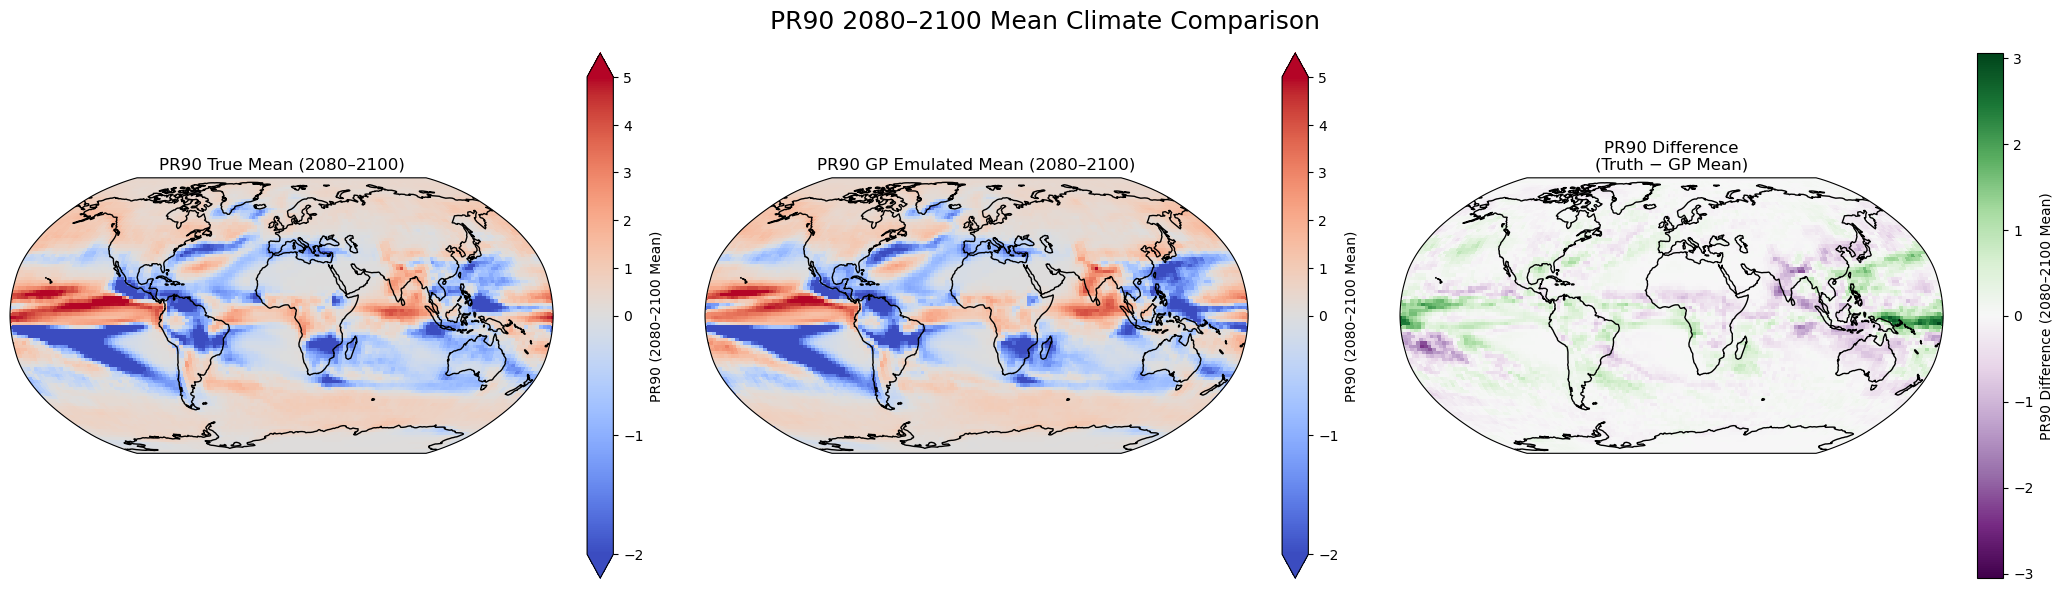

In [14]:
utils.plot_mean_2080_2100(pr90_truth, m_pr90, "PR90", savefig = True, Model = "GP")

In [12]:
dtr_gp = gp_model(X, Y["diurnal_temperature_range"], kernel=['RBF'], kernel_op='add')
dtr_gp.train()

m_dtr, _ = dtr_gp.predict(test_X)
m_dtr = m_dtr.rename({"sample": "time"})

In [13]:
m_dtr = m_dtr.assign_coords(time=tas_truth.time.values)

print(f"NRMSE spatial dtr: {utils.nrmse_spatial(dtr_truth[65:], m_dtr[65:]).mean()}")
print(f"NRMSE global dtr: {utils.nrmse_global(dtr_truth[65:], m_dtr[65:]).mean()}")
print(f"NRMSE total dtr: {utils.nrmse_total(dtr_truth[65:], m_dtr[65:]).mean()}")

NRMSE spatial dtr: 24.374051747712773
NRMSE global dtr: 2.9282321814315386
NRMSE total dtr: 39.01521265487047


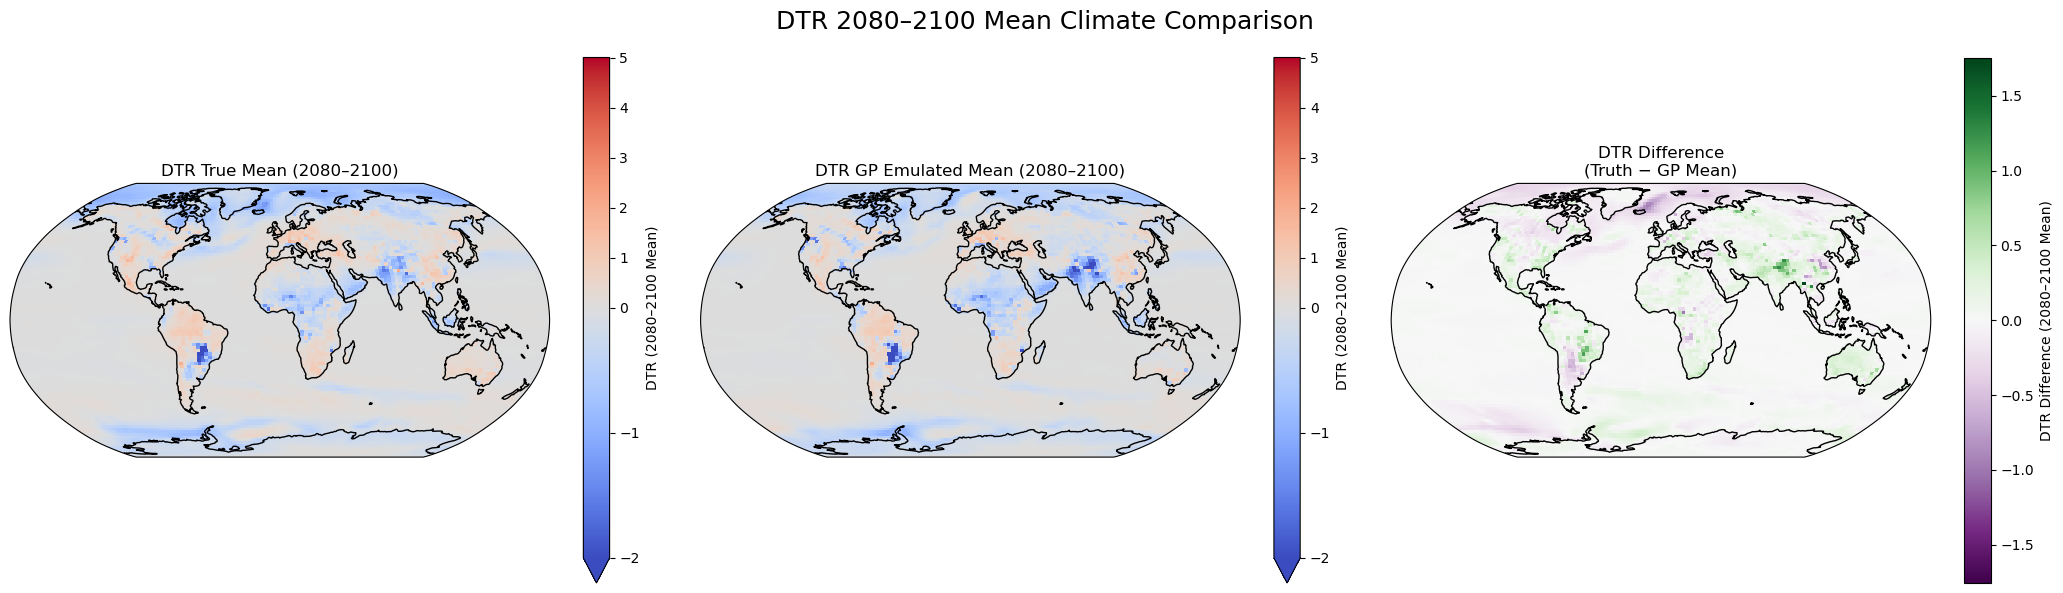

In [15]:
utils.plot_mean_2080_2100(dtr_truth, m_dtr, "DTR", savefig = True, Model = "GP")